Iteration 1, loss = 0.64481370
Validation score: 0.800000
Iteration 2, loss = 0.01600523
Validation score: 0.933333
Iteration 3, loss = 0.01365253
Validation score: 1.000000
Iteration 4, loss = 0.00584499
Validation score: 0.933333
Iteration 5, loss = 0.00527910
Validation score: 0.933333
Iteration 6, loss = 0.00517795
Validation score: 1.000000
Iteration 7, loss = 0.00508438
Validation score: 1.000000
Iteration 8, loss = 0.00505038
Validation score: 1.000000
Iteration 9, loss = 0.00502589
Validation score: 1.000000
Iteration 10, loss = 0.00501015
Validation score: 1.000000
Iteration 11, loss = 0.00499964
Validation score: 1.000000
Iteration 12, loss = 0.00499012
Validation score: 1.000000
Iteration 13, loss = 0.00498173
Validation score: 1.000000
Iteration 14, loss = 0.00497545
Validation score: 1.000000
Iteration 15, loss = 0.00496907
Validation score: 1.000000
Iteration 16, loss = 0.00496367
Validation score: 1.000000
Iteration 17, loss = 0.00495846
Validation score: 1.000000
Iterat

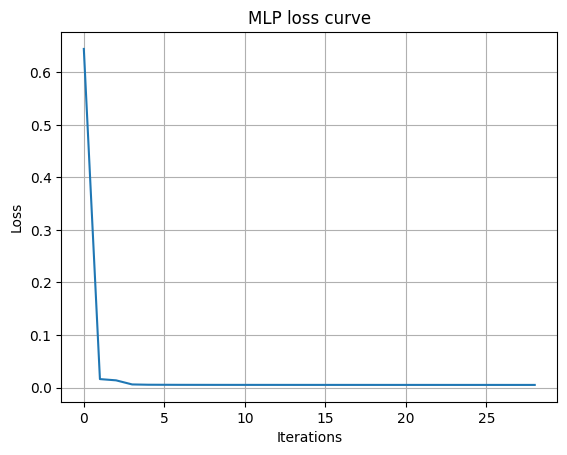

In [1]:
# train_snn_sklearn.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import joblib, os

file_path = "SRBCT.tab"  # put file next to script

# 1. Load and clean
raw = pd.read_csv(file_path, sep="\t", header=0, dtype=object)
df = raw.drop(index=[0,1]).reset_index(drop=True).copy()
feature_cols = [c for c in df.columns if c != 'class']
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
if df[feature_cols].isna().sum().sum() > 0:
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

# 2. Labels + encode
y_raw = df['class'].astype(str).str.strip()
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
X = df[feature_cols].astype(float).values

# 3. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Compute class weights -> integer multipliers -> oversample
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
min_w = class_weights.min()
multipliers = np.round(class_weights / min_w).astype(int)
X_train_aug = []
y_train_aug = []
for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    rep = multipliers[cls]
    for _ in range(rep):
        X_train_aug.append(X_train[idx])
        y_train_aug.append(y_train[idx])
X_train_aug = np.vstack(X_train_aug)
y_train_aug = np.concatenate(y_train_aug)
perm = np.random.RandomState(42).permutation(len(y_train_aug))
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

# 6. Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='relu',
                    solver='adam', alpha=1e-4, batch_size=8,
                    learning_rate_init=0.001, max_iter=1000,
                    early_stopping=True, validation_fraction=0.15,
                    n_iter_no_change=25, random_state=42, verbose=True)
mlp.fit(X_train_aug, y_train_aug)

# 7. Evaluate
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
try:
    y_test_b = label_binarize(y_test, classes=np.arange(num_classes))
    print("Macro ROC AUC (OvR):", roc_auc_score(y_test_b, y_proba, average='macro', multi_class='ovr'))
except Exception as e:
    print("Could not compute ROC AUC:", e)

# 8. Plot loss curve
plt.figure(); plt.plot(mlp.loss_curve_); plt.title('MLP loss curve'); plt.xlabel('Iterations'); plt.ylabel('Loss'); plt.grid(True); plt.show()

# 9. Save artifacts
out_dir = "snn_sr_bct_model_sklearn"
os.makedirs(out_dir, exist_ok=True)
joblib.dump(mlp, out_dir + "/mlp_model.joblib")
joblib.dump(scaler, out_dir + "/scaler.joblib")
np.save(out_dir + "/label_classes.npy", le.classes_, allow_pickle=True)


Loaded model, scaler, and label classes: ['BL' 'EWS' 'NB' 'RMS']

📊 Model Evaluation Metrics:
Accuracy:              0.9880
Balanced Accuracy:     0.9900
Precision (weighted):  0.9884
Recall (weighted):     0.9880
F1-score (weighted):   0.9879
Matthews Corrcoef:     0.9835
Macro ROC AUC (OvR):   1.0000

Detailed classification report:
               precision    recall  f1-score    support
BL             1.000000  1.000000  1.000000  11.000000
EWS            0.966667  1.000000  0.983051  29.000000
NB             1.000000  1.000000  1.000000  18.000000
RMS            1.000000  0.960000  0.979592  25.000000
accuracy       0.987952  0.987952  0.987952   0.987952
macro avg      0.991667  0.990000  0.990661  83.000000
weighted avg   0.988353  0.987952  0.987931  83.000000


c:\Users\saura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


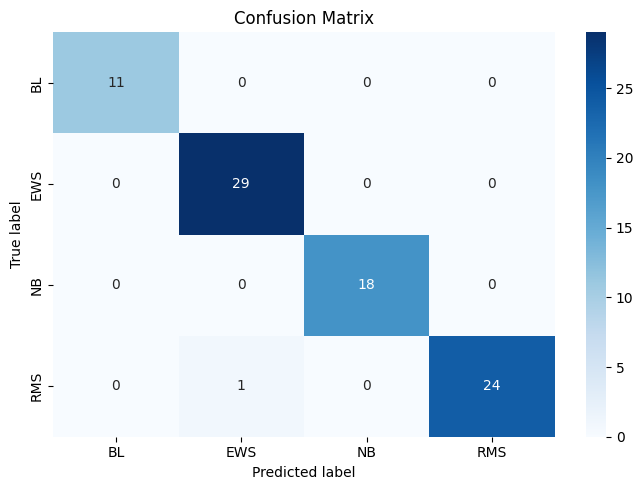


✅ Saved detailed report to 'evaluation_metrics_report.csv'


In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Load trained model + assets
# -----------------------------
model_path = "snn_sr_bct_model_sklearn/mlp_model.joblib"
scaler_path = "snn_sr_bct_model_sklearn/scaler.joblib"
classes_path = "snn_sr_bct_model_sklearn/label_classes.npy"

mlp = joblib.load(model_path)
scaler = joblib.load(scaler_path)
label_classes = np.load(classes_path, allow_pickle=True)
print("Loaded model, scaler, and label classes:", label_classes)

# -----------------------------
# 2️⃣ Load and preprocess dataset
# -----------------------------
data_path = "SRBCT.tab"
df = pd.read_csv(data_path, sep="\t", header=0, dtype=object)
df = df.drop(index=[0, 1]).reset_index(drop=True)

feature_cols = [c for c in df.columns if c != 'class']
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

# Encode labels
y_raw = df['class'].astype(str).str.strip()
le = LabelEncoder()
le.classes_ = label_classes
y_true = le.transform(y_raw)

# Scale features
X = scaler.transform(df[feature_cols].astype(float))

# -----------------------------
# 3️⃣ Make predictions
# -----------------------------
y_pred = mlp.predict(X)
y_pred_proba = mlp.predict_proba(X)

# -----------------------------
# 4️⃣ Evaluation metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# ROC AUC (macro)
try:
    y_true_bin = label_binarize(y_true, classes=np.arange(len(label_classes)))
    roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average='macro', multi_class='ovr')
except Exception as e:
    roc_auc = np.nan
    print("ROC AUC not computed:", e)

print("\n📊 Model Evaluation Metrics:")
print(f"Accuracy:              {accuracy:.4f}")
print(f"Balanced Accuracy:     {balanced_acc:.4f}")
print(f"Precision (weighted):  {precision:.4f}")
print(f"Recall (weighted):     {recall:.4f}")
print(f"F1-score (weighted):   {f1:.4f}")
print(f"Matthews Corrcoef:     {mcc:.4f}")
print(f"Macro ROC AUC (OvR):   {roc_auc:.4f}")

# -----------------------------
# 5️⃣ Detailed classification report
# -----------------------------
report = classification_report(y_true, y_pred, target_names=label_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nDetailed classification report:\n", report_df)

# -----------------------------
# 6️⃣ Confusion matrix visualization
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# -----------------------------
# 7️⃣ Save metrics report
# -----------------------------
report_df.to_csv("evaluation_metrics_report.csv", index=True)
print("\n✅ Saved detailed report to 'evaluation_metrics_report.csv'")


Loading data: SRBCT.tab
Classes: ['BL' 'EWS' 'NB' 'RMS']  -> num_classes: 4
Samples: 83 Raw features: 2308
PCA applied. n_components = 30. Final input dim: 30
Train samples: 66 Test samples: 17
SimpleSNN(
  (fc1): Linear(in_features=30, out_features=256, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


Epoch 001 TrainLoss: 2.8140 ValAcc: 0.3529


Epoch 002 TrainLoss: 1.7930 ValAcc: 0.2353


Epoch 003 TrainLoss: 1.5902 ValAcc: 0.4118


Epoch 004 TrainLoss: 1.4356 ValAcc: 0.4706


Epoch 005 TrainLoss: 1.3357 ValAcc: 0.4706


Epoch 006 TrainLoss: 1.2629 ValAcc: 0.4706


Epoch 007 TrainLoss: 1.1098 ValAcc: 0.5294


Epoch 008 TrainLoss: 0.9471 ValAcc: 0.7059


Epoch 009 TrainLoss: 0.9153 ValAcc: 0.4706


Epoch 010 TrainLoss: 0.6834 ValAcc: 0.5294


Epoch 011 TrainLoss: 0.8126 ValAcc: 0.7059


Epoch 012 TrainLoss: 0.7255 ValAcc: 0.5294


Epoch 013 TrainLoss: 0.7983 ValAcc: 0.8824


Epoch 014 TrainLoss: 0.5172 ValAcc: 0.7647


Epoch 015 TrainLoss: 0.4566 ValAcc: 0.7647


Epoch 016 TrainLoss: 0.3947 ValAcc: 0.8235


Epoch 017 TrainLoss: 0.5589 ValAcc: 0.6471


Epoch 018 TrainLoss: 0.4790 ValAcc: 0.9412


Epoch 019 TrainLoss: 0.4208 ValAcc: 0.7647


Epoch 020 TrainLoss: 0.4136 ValAcc: 0.8235


Epoch 021 TrainLoss: 0.6762 ValAcc: 0.8824


Epoch 022 TrainLoss: 0.4219 ValAcc: 0.8235


Epoch 023 TrainLoss: 0.4534 ValAcc: 0.7059


Epoch 024 TrainLoss: 0.3135 ValAcc: 0.8824


Epoch 025 TrainLoss: 0.4243 ValAcc: 0.7647


Epoch 026 TrainLoss: 0.2730 ValAcc: 0.7647


Epoch 027 TrainLoss: 0.4045 ValAcc: 0.9412


Epoch 028 TrainLoss: 0.4087 ValAcc: 0.6471


Epoch 029 TrainLoss: 0.1867 ValAcc: 0.8235


Epoch 030 TrainLoss: 0.1792 ValAcc: 0.8824


Epoch 031 TrainLoss: 0.2477 ValAcc: 0.8824


Epoch 032 TrainLoss: 0.1603 ValAcc: 0.8824


Epoch 033 TrainLoss: 0.3208 ValAcc: 0.7647


Epoch 034 TrainLoss: 0.1267 ValAcc: 0.9412


Epoch 035 TrainLoss: 0.1646 ValAcc: 0.8235


Epoch 036 TrainLoss: 0.2360 ValAcc: 0.9412


Epoch 037 TrainLoss: 0.3582 ValAcc: 0.8235


Epoch 038 TrainLoss: 0.3090 ValAcc: 0.6471
Early stopping triggered.


Final Test Accuracy: 0.9411764705882353
Classification report:
              precision    recall  f1-score   support

          BL       0.67      1.00      0.80         2
         EWS       1.00      1.00      1.00         6
          NB       1.00      1.00      1.00         4
         RMS       1.00      0.80      0.89         5

    accuracy                           0.94        17
   macro avg       0.92      0.95      0.92        17
weighted avg       0.96      0.94      0.94        17

Confusion matrix:
 [[2 0 0 0]
 [0 6 0 0]
 [0 0 4 0]
 [1 0 0 4]]


Macro ROC AUC (OvR): 1.0
Saved model + preprocessing artifacts and plots to snn_outputs/


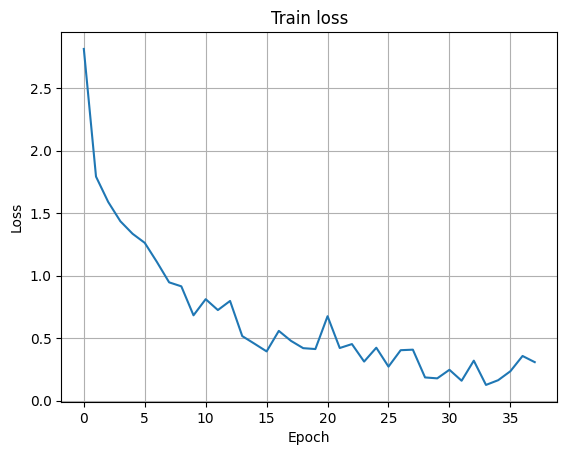

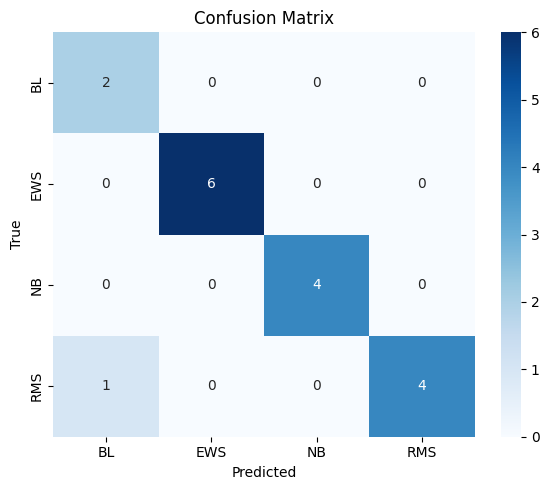

In [14]:
"""
train_snn_srct_safe_pca.py

Train an SNN (with snnTorch) on the SRBCT .tab dataset using Poisson rate encoding.
Includes a safe PCA implementation (auto-limits components to dataset size), training loop, and evaluation metrics.

Run:
    python train_snn_srct_safe_pca.py
"""

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import argparse
from tqdm import tqdm

# ---------------------------
# Arguments / Hyperparameters
# ---------------------------
parser = argparse.ArgumentParser()
parser.add_argument("--data_path", type=str, default="SRBCT.tab")
parser.add_argument("--pca_components", type=int, default=30,
                    help="Number of PCA components. Use None to disable PCA. "
                         "If greater than allowed by data, it will be reduced automatically.")
parser.add_argument("--T", type=int, default=100, help="Number of timesteps for SNN (temporal dimension)")
parser.add_argument("--batch_size", type=int, default=8)
parser.add_argument("--epochs", type=int, default=120)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--max_rate", type=float, default=0.2, help="Max firing probability per timestep for Poisson rate code")
parser.add_argument("--pca_variance_ratio", type=float, default=None,
                    help="If set (e.g. 0.95) use PCA to retain that fraction of variance. Overrides pca_components.")
args = parser.parse_args(args=[])

# reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# ---------------------------
# 1) Load and preprocess data
# ---------------------------
print("Loading data:", args.data_path)
raw = pd.read_csv(args.data_path, sep="\t", header=0, dtype=object)

# drop metadata rows (observed in this dataset)
if raw.shape[0] >= 2:
    df = raw.drop(index=[0, 1]).reset_index(drop=True).copy()
else:
    df = raw.copy()

if 'class' not in df.columns:
    raise RuntimeError("Expected column named 'class' in dataset.")

feature_cols = [c for c in df.columns if c != 'class']
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')

# impute missing with median
if df[feature_cols].isna().sum().sum() > 0:
    print("Imputing missing feature values with column median.")
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

# labels
y_raw = df['class'].astype(str).str.strip()
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Classes:", le.classes_, " -> num_classes:", num_classes)

# features
X = df[feature_cols].astype(float).values
n_samples, n_features = X.shape
print("Samples:", n_samples, "Raw features:", n_features)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 2) Safe PCA logic
# ---------------------------
if args.pca_variance_ratio is not None:
    # Use variance ratio mode (e.g., 0.95) but still constrained by n_samples - 1
    max_components = min(n_samples - 1, n_features)
    print(f"PCA variance ratio mode: target {args.pca_variance_ratio}. Max allowed components = {max_components}")
    pca_temp = PCA(n_components=min(max_components, n_features))
    pca_temp.fit(X_scaled)
    # compute cumulative explained variance and pick required components
    cumvar = np.cumsum(pca_temp.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, args.pca_variance_ratio) + 1)
    n_comp = max(1, min(n_comp, max_components))
    print(f"Selected n_components by variance ratio: {n_comp}")
    pca = PCA(n_components=n_comp, random_state=args.seed)
    X_reduced = pca.fit_transform(X_scaled)
    input_dim = X_reduced.shape[1]
    print(f"PCA applied. n_components = {n_comp}. Final input dim: {input_dim}")
else:
    # User-provided integer or None
    requested_pc = args.pca_components
    if requested_pc is None:
        pca = None
        X_reduced = X_scaled
        input_dim = X_reduced.shape[1]
        print("PCA disabled. Input dim:", input_dim)
    else:
        # safe maximum components
        max_components = min(n_samples - 1, n_features)
        if requested_pc > max_components:
            print(f"Warning: requested PCA components ({requested_pc}) > max allowed ({max_components}).")
            n_comp = max_components
            print(f"Using n_components = {n_comp}")
        else:
            n_comp = requested_pc
        if n_comp <= 0:
            raise ValueError("Computed PCA components <= 0. Check dataset size.")
        pca = PCA(n_components=n_comp, random_state=args.seed)
        X_reduced = pca.fit_transform(X_scaled)
        input_dim = X_reduced.shape[1]
        print(f"PCA applied. n_components = {n_comp}. Final input dim: {input_dim}")

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2,
                                                    random_state=args.seed, stratify=y)
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# ---------------------------
# 3) Dataset & Collate (Poisson rate encoding)
# ---------------------------
class SRBCTDataset(Dataset):
    def __init__(self, X, y, T=100, max_rate=0.2):
        self.X = X.astype(np.float32)
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        self.range = self.max - self.min
        self.range[self.range == 0] = 1.0
        self.y = y
        self.T = T
        self.max_rate = max_rate

    def __len__(self):
        return len(self.y)

    def normalize_to_01(self, x):
        return (x - self.min) / self.range

    def __getitem__(self, idx):
        base = self.X[idx]
        norm = self.normalize_to_01(base)
        label = int(self.y[idx])
        return norm.astype(np.float32), label

def collate_fn_rate(batch):
    norms = np.stack([b[0] for b in batch], axis=0)  # (B, D)
    labels = torch.tensor([b[1] for b in batch], dtype=torch.long)
    B, D = norms.shape
    probs = np.clip(norms * args.max_rate, 0.0, 1.0)  # (B, D)
    rand = np.random.rand(args.T, B, D)
    spikes = (rand < probs[np.newaxis, :, :]).astype(np.float32)  # (T, B, D)
    spikes_tensor = torch.from_numpy(spikes)
    return spikes_tensor.to(args.device), labels.to(args.device)

train_ds = SRBCTDataset(X_train, y_train, T=args.T, max_rate=args.max_rate)
test_ds = SRBCTDataset(X_test, y_test, T=args.T, max_rate=args.max_rate)
train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn_rate)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn_rate)

# ---------------------------
# 4) SNN Model (Leaky LIF neurons)
# ---------------------------
class SimpleSNN(nn.Module):
    def __init__(self, input_dim, n_hidden1=256, n_hidden2=128, n_out=4, spike_grad=None, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, n_hidden1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(n_hidden2, n_out)

    def _move_state_to_device(self, state, device):
        """Move state (Tensor, tuple/list of Tensors, or nested) to device safely."""
        if isinstance(state, torch.Tensor):
            return state.to(device)
        elif isinstance(state, (tuple, list)):
            # recursively move tensors inside tuple/list
            moved = []
            for s in state:
                if isinstance(s, torch.Tensor):
                    moved.append(s.to(device))
                elif isinstance(s, (tuple, list)):
                    # nested structure
                    moved.append(self._move_state_to_device(s, device))
                else:
                    moved.append(s)
            return type(state)(moved)
        else:
            # fallback: try .to()
            try:
                return state.to(device)
            except Exception:
                return state

    def _init_state_flexible(self, lif_module, B, out_features, device):
        """
        Try several common init_leaky call signatures and return a device-moved state.
        Patterns attempted (in order):
          1) lif.init_leaky(B, out_features, device=device)
          2) lif.init_leaky(B, out_features)
          3) lif.init_leaky(B, device=device)
          4) lif.init_leaky(B)
          5) lif.init_leaky()  # last resort
        """
        init_fn = lif_module.init_leaky
        tried = []
        # candidate call variants
        candidates = [
            (B, out_features, {"device": device}),
            (B, out_features, {}),
            (B, {"device": device}),
            (B, {},),
            ((), {})  # call with no positional args
        ]

        for cand in candidates:
            pos_args = cand[0] if isinstance(cand[0], tuple) else (cand[0],) if cand[0] != () else tuple()
            kw = cand[1] if len(cand) > 1 else {}
            try:
                state = init_fn(*pos_args, **kw)
                # if we got here, call succeeded
                return self._move_state_to_device(state, device)
            except TypeError as te:
                tried.append((pos_args, kw, str(te)))
                continue
            except Exception as e:
                # some snntorch versions may raise other errors — still try next
                tried.append((pos_args, kw, str(e)))
                continue

        # If we reach here, no candidate worked — raise informative error
        raise RuntimeError(
            "Could not call init_leaky with known signatures. Tried variants:\n"
            + "\n".join([f"pos={p} kw={k} err={err}" for p, k, err in tried])
        )

    def forward(self, x_seq):
        """
        x_seq: (T, B, D) spike tensor, already on device
        returns: summed logits across time (B, n_out)
        """
        device = x_seq.device
        T, B, D = x_seq.shape

        # Initialize membrane states for both layers in a flexible, version-safe way
        mem1 = self._init_state_flexible(self.lif1, B, self.fc1.out_features, device)
        mem2 = self._init_state_flexible(self.lif2, B, self.fc2.out_features, device)

        # Accumulate logits across timesteps
        out_accum = torch.zeros(B, self.fc3.out_features, device=device)

        for t in range(T):
            inp_t = x_seq[t]  # shape (B, D)
            cur1 = self.fc1(inp_t)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            out_t = self.fc3(spk2)
            out_accum += out_t

        return out_accum


spike_grad = surrogate.fast_sigmoid(slope=25)
model = SimpleSNN(input_dim=input_dim, n_hidden1=256, n_hidden2=128, n_out=num_classes,
                  spike_grad=spike_grad, beta=0.95).to(args.device)
print(model)

# ---------------------------
# 5) Training setup
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()
# Backward-compatible ReduceLROnPlateau setup
try:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=8, verbose=True)
except TypeError:
    # Older PyTorch versions do not support 'verbose'
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=8)


# ---------------------------
# 6) Training & evaluation helpers
# ---------------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for spikes, labels in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(spikes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    return running_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for spikes, labels in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(spikes)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    return y_true, y_pred

best_val_acc = 0.0
patience = 20
no_improve = 0
history = {"train_loss": [], "val_acc": []}
os.makedirs("snn_outputs", exist_ok=True)

for epoch in range(1, args.epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    y_val_true, y_val_pred = eval_model(model, test_loader)
    val_acc = accuracy_score(y_val_true, y_val_pred)
    scheduler.step(1.0 - val_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch:03d} TrainLoss: {train_loss:.4f} ValAcc: {val_acc:.4f}")
    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "snn_outputs/best_snn.pth")
    else:
        no_improve += 1
    if no_improve >= patience:
        print("Early stopping triggered.")
        break

# ---------------------------
# 7) Final evaluation & metrics
# ---------------------------
model.load_state_dict(torch.load("snn_outputs/best_snn.pth", map_location=args.device))
y_test_true, y_test_pred = eval_model(model, test_loader)
acc = accuracy_score(y_test_true, y_test_pred)
print("Final Test Accuracy:", acc)
print("Classification report:")
print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))
cm = confusion_matrix(y_test_true, y_test_pred)
print("Confusion matrix:\n", cm)

# Attempt ROC AUC
try:
    model.eval()
    proba_list = []
    with torch.no_grad():
        for spikes, labels in tqdm(test_loader, desc="Getting probs", leave=False):
            logits = model(spikes)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            proba_list.append(probs)
    proba_all = np.vstack(proba_list)
    y_test_bin = np.eye(num_classes)[y_test_true]
    roc_auc = roc_auc_score(y_test_bin, proba_all, average="macro", multi_class="ovr")
    print("Macro ROC AUC (OvR):", roc_auc)
except Exception as e:
    print("Could not compute ROC AUC:", e)

# ---------------------------
# 8) Save artifacts and plots
# ---------------------------
joblib.dump(scaler, "snn_outputs/scaler.joblib")
if pca is not None:
    joblib.dump(pca, "snn_outputs/pca.joblib")
joblib.dump(le.classes_, "snn_outputs/label_classes.npy")
plt.figure(); plt.plot(history["train_loss"]); plt.title("Train loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.savefig("snn_outputs/train_loss.png")
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues"); plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig("snn_outputs/confusion_matrix.png")
print("Saved model + preprocessing artifacts and plots to snn_outputs/")
